In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from rich.table import Table
from IPython.display import display, HTML
from pathlib import Path

import jaxtyping

In [2]:
import sys
# Make sure exercises are in the path
exercises_dir = Path("../exercises").resolve()
section_dir = (exercises_dir / "part4_superposition_and_saes").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, hist
from part4_superposition_and_saes.utils import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_features_in_Nd_discrete,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot,
    plot_features_in_2d_hierarchy_labeled
)
import part4_superposition_and_saes.tests as tests
import part4_superposition_and_saes.solutions as solutions

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

current PyTorch install was built with MPS enabled.
MPS is available


/Users/daniellee/Library/Caches/pypoetry/virtualenvs/toy-hierarchy-NsY2iPjH-py3.12/lib/python3.12/site-packages/accelerate/utils/imports.py:282: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


current PyTorch install was built with MPS enabled.
MPS is available


# Create Class to Store Tree

have a list of elements "0" or "1", or "0.0" (to indicate first child of "0"), and so on 

In [3]:
import pandas as pd

In [3]:
class Node:
    def __init__(self, val = 0):
        self.children = []
        self.val = val

    # def __str__(self):
    #     return str(index)

    def add_child(self, child = None):
        if child is None:
            self.children.append(Node())
        else:
            self.children.append(child)

    def __repr__(self):
        return f"Node {self.val}: {self.children}"

class Tree:
    def __init__(self, node = None):
        if node is not None:
            self.root = node
        else:
            self.root = Node()
        # self.tree_list = self.to_list()
        
    def to_list(self):
        return self.returnInorder(self.root, result = [])
    
    def returnInorder(self, node, string="", result = []):
            
        if len(node.children) == 0:
            return result
            
        for i in range(len(node.children)):
            if string == "":
                new_string = f"{i}"
            else:
                new_string = f"{string}.{i}"
            result.append(new_string)
            self.returnInorder(node.children[i], new_string, result)
            # result.append(new_string)

        return result            

In [4]:
branching_factor = 3
depth = 3

In [5]:
def construct_tree(branching_factor, depth):
    a = Node()
    if depth == 0:
        return a
    for branching_factor_i in range(branching_factor):
        a.add_child(construct_tree(branching_factor, depth - 1))
    return a
            

In [25]:
import random

In [158]:
def sample(tree, early_stop_prob=0.5, branching_factor=2, depth=4):
    current_node = tree.root
    path = []

    current_depth = 0
    total_nodes = branching_factor ** (depth + 1) - 2
    
    while current_node.children:
        child_index = random.randint(0, len(current_node.children) - 1)
        path.append(str(child_index))
        current_node = current_node.children[child_index]
        
        current_depth += 1
        # early_stop_prob = (branching_factor ** (current_depth + 1) - 2) / total_nodes
        early_stop_prob = (branching_factor ** (current_depth)) / total_nodes
        # Check for early stopping only if path length is more than 0
        if len(path) > 0 and random.random() < early_stop_prob:
            break
    
    return ".".join(path)

def sample_equal_probability(tree, size):
    return t.randint(low=0, high = len(tree.to_list()), size = size)
                  
def get_leaf_indices(tree):
    all_paths = tree.to_list()
    max_dots = max(path.count('.') for path in all_paths)
    leaf_paths = [path for path in all_paths if path.count('.') == max_dots]
    leaf_paths_index = [all_paths.index(path) for path in leaf_paths]
    return leaf_paths_index

def sample(valid_indices, size):
    return t.tensor(np.random.choice(valid_indices, size=size), dtype = t.int)

In [159]:
get_leaf_indices(a_tree)

[1, 2, 4, 5]

In [162]:
sample(range(len(a_tree.to_list())), (1,3))

tensor([[4, 0, 0]], dtype=torch.int32)

In [84]:
sample_leaf_nodes(a_tree)
n = 1
all_paths = a_tree.to_list()
max_dots = max(path.count('.') for path in all_paths)
print(max_dots)
leaf_paths = [path for path in all_paths if path.count('.') == max_dots]
print(leaf_paths)
chosen_paths = [random.choice(leaf_paths) for _ in range(n)]

1
['0.0', '0.1', '1.0', '1.1']


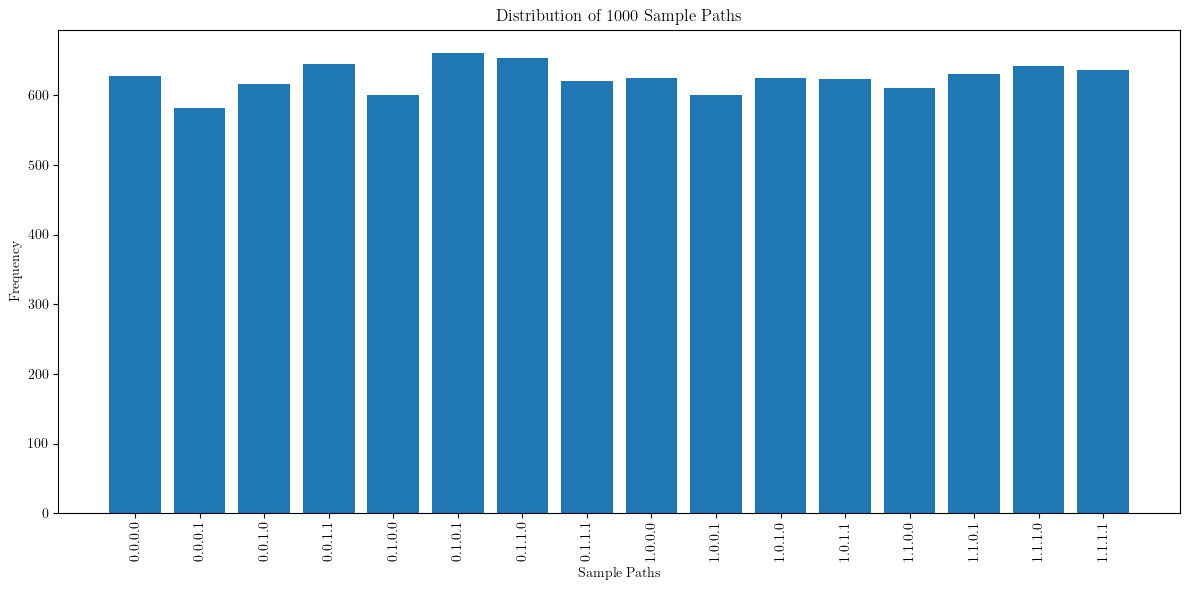

In [112]:
import matplotlib.pyplot as plt
from collections import Counter

example_tree = Tree(construct_tree(2, 4))
samples = sample_leaf_nodes(example_tree, n = 10000)

# Count the occurrences of each unique path
path_counts = Counter(samples)

# Sort the paths by their string representation for consistent ordering
sorted_paths = sorted(path_counts.keys())
counts = [path_counts[path] for path in sorted_paths]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_paths)), counts)
plt.xticks(range(len(sorted_paths)), sorted_paths, rotation=90)
plt.xlabel('Sample Paths')
plt.ylabel('Frequency')
plt.title('Distribution of 1000 Sample Paths')
plt.tight_layout()
plt.show()

In [113]:
## sampling choose one from the list --> then get what features are turned on (list of 0 and 1)

a_tree = Tree(construct_tree(2, 3))

In [114]:
a_tree.to_list()

['0',
 '0.0',
 '0.0.0',
 '0.0.1',
 '0.1',
 '0.1.0',
 '0.1.1',
 '1',
 '1.0',
 '1.0.0',
 '1.0.1',
 '1.1',
 '1.1.0',
 '1.1.1']

In [115]:
a_tree.to_list()

['0',
 '0.0',
 '0.0.0',
 '0.0.1',
 '0.1',
 '0.1.0',
 '0.1.1',
 '1',
 '1.0',
 '1.0.0',
 '1.0.1',
 '1.1',
 '1.1.0',
 '1.1.1']

In [118]:
path_to_tensor = {path: t.tensor([1 if any(p == '.'.join(path.split('.')[:i+1]) for i in range(len(path.split('.')))) else 0 for p in all_paths], 
                               device=device).to(t.int) for path in all_paths}

path_to_tensor = {path: t.tensor([1 if path.startswith(p) else 0 for p in all_paths], 
                               device=device).to(t.int) for path in all_paths}

path_to_tensor

{'0': tensor([1, 0, 0, 0, 0, 0], device='mps:0', dtype=torch.int32),
 '0.0': tensor([1, 1, 0, 0, 0, 0], device='mps:0', dtype=torch.int32),
 '0.1': tensor([1, 0, 1, 0, 0, 0], device='mps:0', dtype=torch.int32),
 '1': tensor([0, 0, 0, 1, 0, 0], device='mps:0', dtype=torch.int32),
 '1.0': tensor([0, 0, 0, 1, 1, 0], device='mps:0', dtype=torch.int32),
 '1.1': tensor([0, 0, 0, 1, 0, 1], device='mps:0', dtype=torch.int32)}

In [65]:
all_paths

['0', '0.0', '0.1', '1', '1.0', '1.1']

In [53]:
a_tree.to_list()

['0',
 '0.0',
 '0.0.0',
 '0.0.1',
 '0.1',
 '0.1.0',
 '0.1.1',
 '1',
 '1.0',
 '1.0.0',
 '1.0.1',
 '1.1',
 '1.1.0',
 '1.1.1']

In [166]:
input_tensor = t.stack([t.tensor([1 if any(p == '.'.join(path.split('.')[:i+1]) for i in range(len(path.split('.')))) else 0 for p in all_paths], 
                               device=device).to(t.int) for path in all_paths], dim = 0)


indices = sample(range(len(a_tree.to_list())), (1,3))
print(indices)
input_tensor[indices]

tensor([[2, 4, 1]], dtype=torch.int32)


tensor([[[1, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 1, 0],
         [1, 1, 0, 0, 0, 0]]], device='mps:0', dtype=torch.int32)

In [149]:
batch_size = 10
n_instances = 10

a_tree = Tree(construct_tree(2, 2))
tree = a_tree
n_features = len(tree.to_list())  # Number of features is the length of a full path

feat = t.zeros((batch_size, n_instances, n_features), dtype = t.int)#.to(t.int)
all_paths = tree.to_list()


sampled_paths = self.sample(tree, n = batch_size * n_instances)
index = 0
for b in range(batch_size):
    for i in range(self.cfg.n_instances):
        feat[b, i] = self.path_to_tensor[sampled_paths[index]]
        index += 1

return feat.to(t.float)

{'0': tensor([1, 0, 0, 0, 0, 0], device='mps:0', dtype=torch.int32), '0.0': tensor([1, 1, 0, 0, 0, 0], device='mps:0', dtype=torch.int32), '0.1': tensor([1, 0, 1, 0, 0, 0], device='mps:0', dtype=torch.int32), '1': tensor([0, 0, 0, 1, 0, 0], device='mps:0', dtype=torch.int32), '1.0': tensor([0, 0, 0, 1, 1, 0], device='mps:0', dtype=torch.int32), '1.1': tensor([0, 0, 0, 1, 0, 1], device='mps:0', dtype=torch.int32)}


In [ ]:
def generate_batch(self: Model, batch_size) -> Float[Tensor, "batch_size instances features"]:
    '''
    Generates a batch of data using the tree structure and sample_equal_probability function.
    '''
    tree = self.cfg.tree
    n_features = len(tree.to_list())  # Number of features is the length of the full path list

    feat = t.zeros((batch_size, self.cfg.n_instances, n_features), device=self.device)
    all_paths = tree.to_list()
    path_to_tensor = {path: t.tensor([1 if any(p == '.'.join(path.split('.')[:i+1]) for i in range(len(path.split('.')))) else 0 for p in all_paths], 
                                   device=self.device).to(t.int) for path in all_paths}

    for b in range(batch_size):
        for i in range(self.cfg.n_instances):
            sampled_path = sample_equal_probability(tree)
            feat[b, i] = path_to_tensor[sampled_path[0]].clone()

    return feat

# Define Model

In [173]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

@dataclass
class Config:
    # We optimize n_instances models in a single training loop to let us sweep over
    # sparsity or importance curves  efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    tree: Tree
    n_features: int = 6
    # tree_depth: int = 2
    # branching_factor: int = 2
    n_hidden: int = 2
    partial_paths: bool = True

class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None: feature_probability = t.ones(())
        if isinstance(feature_probability, float): feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))
        if importance is None: importance = t.ones(())
        if isinstance(importance, float): importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)

        self.partial_paths = self.cfg.partial_paths

        if self.cfg.partial_paths:
            self.valid_indices = list(range(self.cfg.n_features))
        else:
            self.valid_indices = get_leaf_indices(self.cfg.tree)

        print(self.valid_indices)

        self.device = device

        all_paths = tree.to_list()
        self.input_tensor = t.stack([t.tensor([1 if any(p == '.'.join(path.split('.')[:i+1]) 
                                                        for i in range(len(path.split('.')))) else 0 for p in all_paths], 
                               device=device).to(t.int) for path in all_paths], dim = 0)


    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)

    def sample(self: Model, size):
        return t.tensor(np.random.choice(self.valid_indices, size=size), dtype = t.int)
    
    def generate_batch(self: Model, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data using the tree structure and sample_equal_probability function.
        '''
        # feat = t.zeros((batch_size, self.cfg.n_instances, self.cfg.n_features), dtype = t.int, device = self.device)


        indices = self.sample(size = (batch_size, self.cfg.n_instances))
        feat = self.input_tensor[indices]


        # sampled_paths = self.sample(tree, n = batch_size * self.cfg.n_instances)
        # index = 0
        # for b in range(batch_size):
        #     for i in range(self.cfg.n_instances):
        #         feat[b, i] = self.path_to_tensor[sampled_paths[index]]
        #         index += 1

        return feat.to(t.float)

    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `self.importance` will always have shape (n_instances, n_features).
        '''
        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, 'batch instances features -> instances', 'mean').sum()
        return loss

    def calculate_loss_per_instance(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:

            https://transformer-circuits.pub/2022/toy_model/index.html#demonstrating-setup-loss

        Remember, `self.importance` will always have shape (n_instances, n_features).
        '''
        error = self.importance * ((batch - out) ** 2)
        losses = einops.reduce(error, 'batch instances features -> instances', 'mean')
        return losses

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):

                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)

In [174]:
a_tree = Tree(construct_tree(2, 2))
cfg = Config(
    n_instances = 6,
    tree = a_tree,
    n_hidden = 2,
    partial_paths = True,
    n_features = len(a_tree.to_list())
)

importance = (1.0 ** t.arange(cfg.n_features))
importance = einops.rearrange(importance, "features -> () features")
feature_probability = (1 ** -t.linspace(0, 1, cfg.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

In [175]:
np.random.seed(42)
t.random.manual_seed(42)

model = Model(
    cfg = cfg,
    device = device,
)

model.optimize(steps=10000)


[0, 1, 2, 3, 4, 5]


  0%|          | 0/10000 [00:00<?, ?it/s]

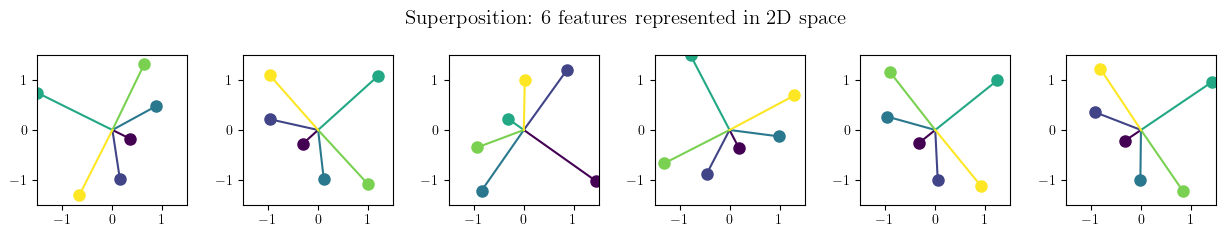

In [176]:
plot_features_in_2d(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    n_rows = 1
)

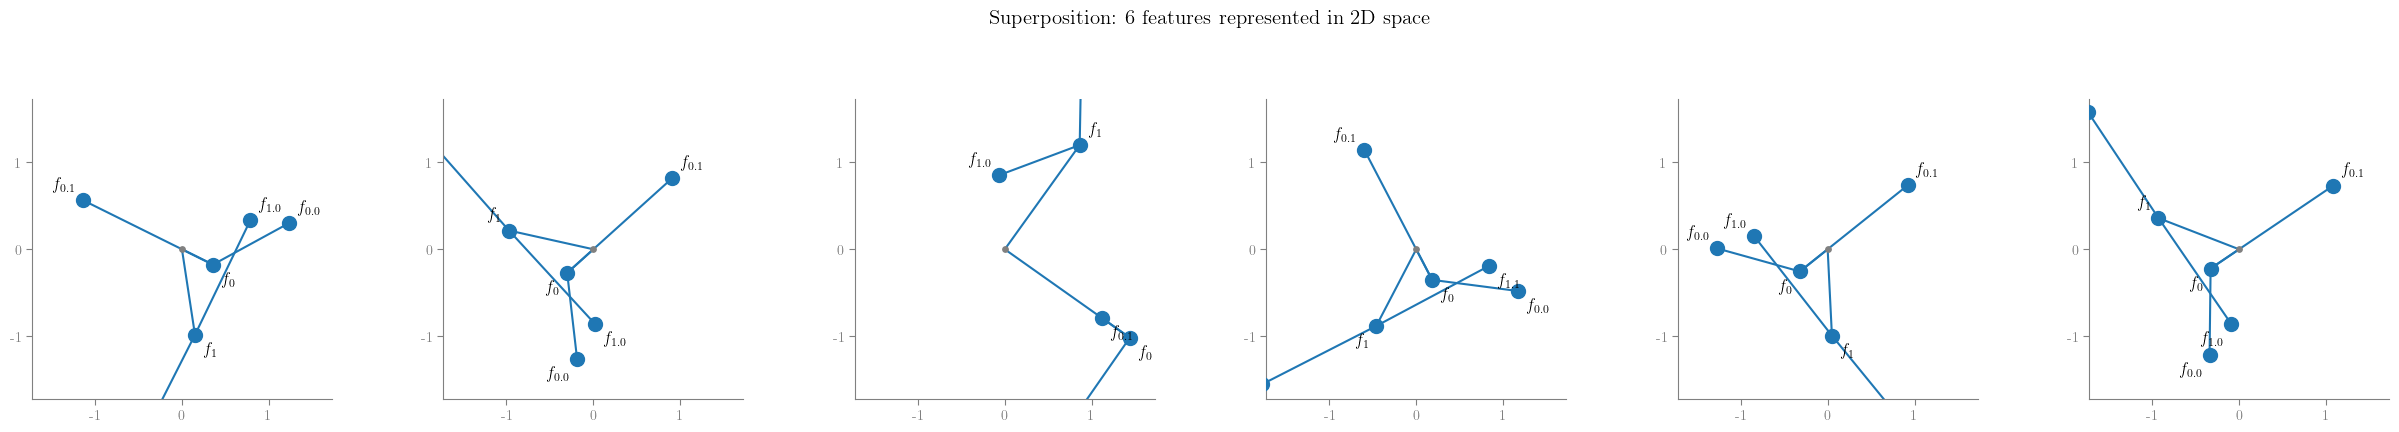

In [177]:
plot_features_in_2d_hierarchy_labeled(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    n_rows = 1
)

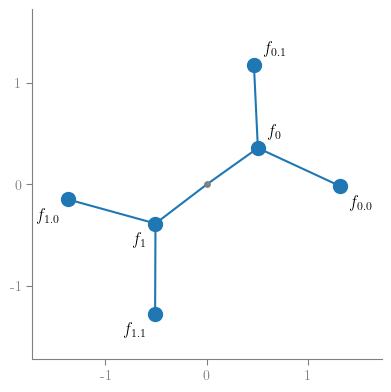

In [11]:
plot_features_in_2d_hierarchy_labeled(
    model.W[3, :].detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = None,
    n_rows = 1
)

In [12]:
plot_features_in_Nd(
    model.W,
    height = 600,
    width = 1400,
    title = "n_features = 6, d_hidden = 2, early_stopping=False",
)

In [13]:
plot_features_in_Nd(
    model.W / model.W.norm(dim=1, keepdim=True),
    height = 600,
    width = 1400,
    title = "n_features = 6, d_hidden = 2, early_stopping=False",
)

In [14]:
def vis_projections(W, b_final, input):
    import plotly.graph_objects as go

    input_torch = t.tensor(input).to(W)
    input_dir = (W * input_torch).sum(dim=-1)
    print(input_dir)

    projs = einops.einsum(input_dir, W, 'd_hidden, d_hidden n_features -> n_features')
    # print(projs)

    projs_w_bias = projs + b_final
    # print(projs_w_bias)

    # Convert tensor data to numpy arrays
    projs_np = projs.detach().cpu().numpy()
    projs_w_bias_np = projs_w_bias.detach().cpu().numpy()

    # Create the bar chart
    fig = go.Figure()

    # Add bars for original projections
    fig.add_trace(go.Bar(
        x=np.arange(len(projs_np)),
        y=projs_np,
        name='Without Bias',
        marker_color='blue'
    ))

    # Add bars for projections with bias
    fig.add_trace(go.Bar(
        x=np.arange(len(projs_w_bias_np)),
        y=projs_w_bias_np,
        name='With Bias',
        marker_color='orange'
    ))

    # Update layout
    fig.update_layout(
        title=f'Projections for {input}',
        xaxis_title='Feature Index',
        yaxis_title='Projection Value',
        barmode='group', bargap=0.15, bargroupgap=0.1,
        width=700, height=350,
    )

    fig.show()

In [15]:
idx = 0

W = model.W[idx]
b_final = model.b_final[idx]

In [16]:
inputs = [
    [1, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1],
]

for input in inputs:
    vis_projections(W, b_final, input)

tensor([1.0542, 0.8135], device='mps:0', grad_fn=<SumBackward1>)


tensor([-0.3194,  1.2593], device='mps:0', grad_fn=<SumBackward1>)


tensor([ 0.4303, -1.3156], device='mps:0', grad_fn=<SumBackward1>)


tensor([-0.9538, -0.9934], device='mps:0', grad_fn=<SumBackward1>)


In [17]:
print(W[:, 2] @ W[:, 3])
print((W[:, 0] + W[:, 2]) @ (W[:, 3]))

tensor(-0.2972, device='mps:0', grad_fn=<DotBackward0>)
tensor(-0.0011, device='mps:0', grad_fn=<DotBackward0>)


In [18]:
print(W[:, 2] @ W[:, 2])
print((W[:, 0] + W[:, 2]) @ (W[:, 2]))

tensor(0.7882, device='mps:0', grad_fn=<DotBackward0>)
tensor(1.0843, device='mps:0', grad_fn=<DotBackward0>)


## Children can be zero, with 50% chance

In [19]:
cfg = Config(
    n_instances = 10,
    n_features = 6,
    n_hidden = 2,
)

t.random.manual_seed(42)
np.random.seed(42)

model = Model(
    cfg = cfg,
    device = device,
    importance = None,
    feature_probability = None,
    early_stopping=True,
)
model.optimize(steps=25000)

  0%|          | 0/25000 [00:00<?, ?it/s]

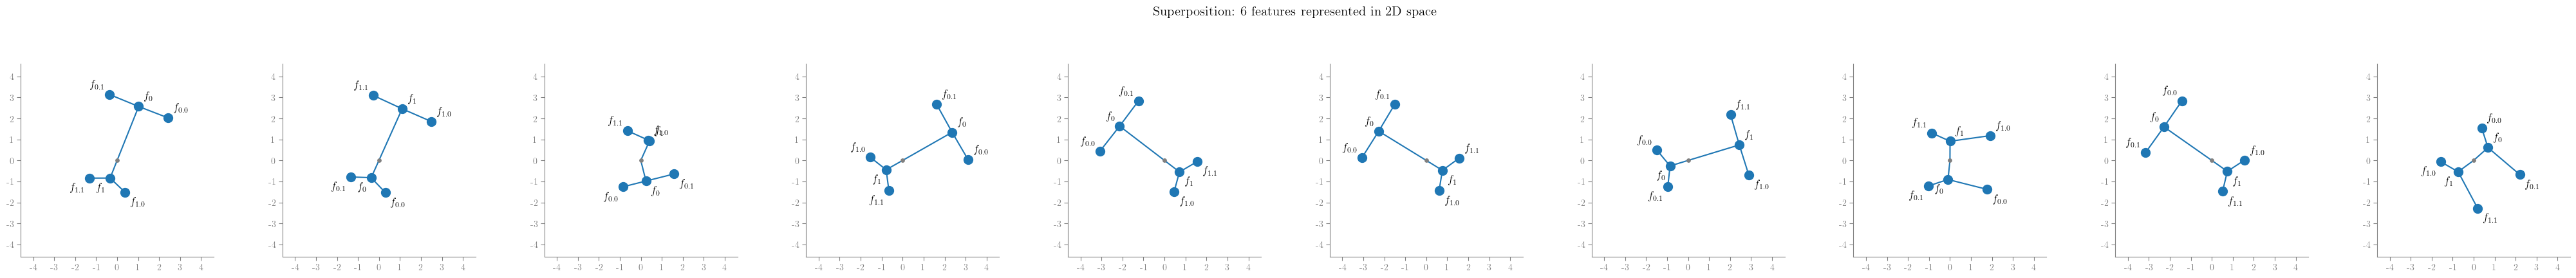

In [20]:
plot_features_in_2d_hierarchy_labeled(
    model.W.detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = f"Superposition: {cfg.n_features} features represented in 2D space",
    n_rows = 1,
    absolute_limits=4.0,
)

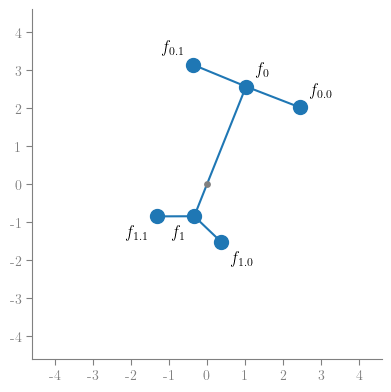

In [24]:
plot_features_in_2d_hierarchy_labeled(
    model.W[0, :].detach(),
    colors = einops.repeat(t.arange((model.cfg.n_features)), 'n_features -> n_instances n_features', n_instances=model.cfg.n_instances) / 5,
    title = None,
    n_rows = 1,
    absolute_limits=4.0,
)

In [25]:
batch = model.generate_batch(100)
out = model(batch)

model.calculate_loss_per_instance(out, batch)

tensor([0.0012, 0.0015, 0.0217, 0.0012, 0.0011, 0.0012, 0.0014, 0.0021, 0.0012,
        0.0020], device='mps:0', grad_fn=<MeanBackward1>)

In [26]:
idx = 0

W = model.W[idx]
b_final = model.b_final[idx]

inputs = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1],
]

for input in inputs:
    vis_projections(W, b_final, input)

tensor([1.0268, 2.5695], device='mps:0', grad_fn=<SumBackward1>)


tensor([-0.3336, -0.8402], device='mps:0', grad_fn=<SumBackward1>)


tensor([2.4355, 2.0247], device='mps:0', grad_fn=<SumBackward1>)


tensor([-0.3717,  3.1451], device='mps:0', grad_fn=<SumBackward1>)


tensor([ 0.3746, -1.5161], device='mps:0', grad_fn=<SumBackward1>)


tensor([-1.3154, -0.8434], device='mps:0', grad_fn=<SumBackward1>)


In [27]:
plot_features_in_Nd(
    model.W[:2],
    height = 600,
    width = 1400,
    title = "n_features = 6, d_hidden = 2, early_stopping=True",
)

In [28]:
W[:, 4] @ (W[:, 0] + W[:, 2])

tensor(0.3564, device='mps:0', grad_fn=<DotBackward0>)

In [29]:
W[:, 4] / W[:, 4].norm(dim=0, keepdim=True) @ (W[:, 0] + W[:, 2]) / (W[:, 0] + W[:, 2]).norm(dim=0, keepdim=True)

tensor([0.1149], device='mps:0', grad_fn=<DivBackward0>)

In [30]:
W[:, 4] / W[:, 4].norm(dim=0, keepdim=True) @ (W[:, 2]) / (W[:, 2]).norm(dim=0, keepdim=True)

tensor([0.9238], device='mps:0', grad_fn=<DivBackward0>)

## 3D

In [31]:
tree_depth = 2
n_features = 2**(tree_depth + 1) - 2
n_hidden = 3

cfg_3d = Config(
    n_instances = 5,
    n_features = n_features,
    n_hidden = n_hidden,
    tree_depth=tree_depth,
)

model_3d = Model(
    cfg = cfg_3d,
    device = device,
    importance = None,
    feature_probability = None,
    early_stopping=True,
)
model_3d.optimize(steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
idx = 0

W_3d = model_3d.W[idx]
b_final_3d = model_3d.b_final[idx]

inputs = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1],
]

for input in inputs:
    vis_projections(W_3d, b_final_3d, input)

tensor([-0.4281,  0.6138,  0.6633], device='mps:0', grad_fn=<SumBackward1>)


tensor([-0.3519, -0.7331, -0.5823], device='mps:0', grad_fn=<SumBackward1>)


tensor([0.2931, 1.4312, 0.3724], device='mps:0', grad_fn=<SumBackward1>)


tensor([0.4321, 0.4427, 1.3768], device='mps:0', grad_fn=<SumBackward1>)


tensor([-1.3388,  0.0149, -0.9275], device='mps:0', grad_fn=<SumBackward1>)


tensor([ 0.6319, -1.1530, -0.6481], device='mps:0', grad_fn=<SumBackward1>)


In [33]:
import torch
import plotly.graph_objects as go
import numpy as np

# Assuming W_3d is your tensor with shape [3, 6]
# If you don't have this tensor, you can create a random one for testing:
# W_3d = torch.rand(3, 6)

# Convert the tensor to numpy for easier handling
W_3d_np = W_3d.detach().cpu().numpy()

# Create a figure
fig = go.Figure()

# Define colors for each level of the tree
colors = ['blue', 'green', 'red']

# Function to add a vector to the plot
def add_vector(start, end, name, color):
    fig.add_trace(go.Scatter3d(
        x=[start[0], end[0]],
        y=[start[1], end[1]],
        z=[start[2], end[2]],
        mode='lines',
        name=name,
        line=dict(width=5, color=color)
    ))
    fig.add_trace(go.Scatter3d(
        x=[end[0]],
        y=[end[1]],
        z=[end[2]],
        mode='markers',
        name=f'{name} end',
        marker=dict(size=5, color=color)
    ))

# Plot level 1 (parent nodes)
for i in range(2):
    start = np.zeros(3)
    end = W_3d_np[:, i]
    add_vector(start, end, f'Vector {i}', colors[0])

# Plot level 2 (children of node 0)
parent = W_3d_np[:, 0]
for i in range(2, 4):
    start = parent
    end = parent + W_3d_np[:, i]
    add_vector(start, end, f'Vector {i}', colors[1])

# Plot level 3 (children of node 1)
parent = W_3d_np[:, 1]
for i in range(4, 6):
    start = parent
    end = parent + W_3d_np[:, i]
    add_vector(start, end, f'Vector {i}', colors[2])

# Set layout
fig.update_layout(
    title='3D Vector Binary Tree Visualization',
    scene=dict(
        xaxis=dict(range=[-2, 2], title='X'),
        yaxis=dict(range=[-2, 2], title='Y'),
        zaxis=dict(range=[-2, 2], title='Z'),
        aspectmode='cube'
    ),
    # scene=dict(
    #     xaxis_title='X',
    #     yaxis_title='Y',
    #     zaxis_title='Z',
    #     aspectmode='cube'  # This ensures the 3D space is a cube
    # ),
    showlegend=True,
    width=600, height=600
)

# Show the plot
fig.show()

In [34]:
plot_features_in_Nd(
    model_3d.W,
    height = 600,
    width = 1400,
    title = "n_features = 6, d_hidden = 3, early_stopping=True",
)